<a href="https://colab.research.google.com/github/lucarubini/LINKS_DeepLearning_Course/blob/main/time_series_tutorial/TF_time_series_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting

Questo tutorial è un'introduzione alla previsione delle serie temporali *(time series forecasting)* utilizzando **TensorFlow**. 

Si costruiranno diversi tipi di modelli tra cui le reti neurali convoluzionali e ricorrenti (CNN e RNN).

Questo tutorial è suddiviso in due parti principali, con sottosezioni:

* Previsione per un singolo passaggio temporale:
  * Una caratteristica unica.
  * Tutte le caratteristiche.
* Previsione a più passaggi:
  * Colpo singolo: fai le previsioni tutte in una volta.
  * Autoregressivo: effettua una previsione alla volta e invia l'output al modello.

## Setup

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Dataset Meteorologici

Questo tutorial utilizza una <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">serie di dati meteoreologici</a> registrata dal <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

Questo set di dati contiene **14** diverse caratteristiche come la temperatura dell'aria, la pressione atmosferica e l'umidità. Questi sono stati raccolti ogni 10 minuti, a partire dal 2003. Per l'efficienza, si utilizzerà solo i dati raccolti tra il 2009 e il 2016.

Questa sezione del set di dati è stato preparato da François Chollet per il suo libro <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

Questo tutorial si struttura solo sulle **previsioni orarie**. Si fa un sub-campionamento dei dati da intervalli di 10 minuti a intervalli di un'ora:

In [ ]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [ ]:
#Capiamo meglio il passo di slicing, che cosa fa veramente
x = [i for i in range(33)]
print("x: {}".format(x))
print("x[5::6]: {}".format(x[5::6]))

Diamo uno sguardo ai dati. Ecco le prime righe del dataset:

In [ ]:
df.head()

Ecco l'evoluzione di alcune caratteristiche nel tempo:






In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

# Ispezionare e pulire i dati

Guardiamo ora le statistiche aggregate dei dati, serve per cercare outliers ed eventuali errori:

In [ ]:
df.describe().transpose()

#### Velocità del vento

Possiamo focalizzarci sui valori di minimo `min` e massimo valore della velocitta' del ventp `max.`  `(wv (m/s)`) . Il valore `-9999` è presumibilmente errato.

C'è una colonna direzione del vento separata, quindi la velocità deve essere maggiore di zero (`>=0`). Sosituiamola con zeri

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### Analisi delle caratteristiche (features)

Prima di creare un modello, è **importante** comprendere i dati ed essere sicuri di passare al modello dati formattati e organizzati in modo appropriato.

#### Vento
L'ultima colonna dei dati, `wd (deg)` dà la direzione del vento in unità di gradi. Gli angoli non sono un buon input del modello: 360° e 0° dovrebbero essere vicini l'uno all'altro e sovrapporsi. La direzione non dovrebbe avere importanza se il vento non soffia.

In questo momento la distribuzione dei dati sul vento si presenta così:

In [ ]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

Ma questa informazione sarà più facile per il modello da interpretare se si converte la direzione e la velocità del vento colonne in un **vettore** del vento:

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

La distribuzione dei vettori del vento è molto più semplice da interpretare correttamente per il modello, guardiamo ad esempio la figura:

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Tempo

Allo stesso modo, il valore `Date Time` colonna è molto utile, ma non in questa forma di stringa. Iniziamo convertendolo in secondi:

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Simile alla direzione del vento, il tempo in secondi non è un `input` utile del modello. Essendo dati meteorologici, il tempo ha una periodicità giornaliera e annuale chiara. Ci sono molti modi in cui puoi gestire la periodicità.

È possibile ottenere segnali utilizzabili utilizzando le trasformate seno e coseno per cancellare i segnali *Ora del giorno* e *Ora dell'anno*:

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Ciò consente al modello di accedere alle funzioni di frequenza più importanti (se è possibile sapere in anticipo quali siano le frequenze importanti). 

Se non si dispone di tali informazioni, è possibile determinare quali frequenze sono importanti estraendo le caratteristiche con la <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Fast Fourier Transform</a> . Per verificare le ipotesi, ecco il `tf.signal.rfft` della temperatura nel corso del tempo. Notare i picchi evidenti a frequenze vicine  `1/year` and `1/day`:


In [ ]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### PArtizionamento dei dati (Train, Valid, Test)

Potrai utilizzare una divisione `(70%, 20%, 10%)` per i set di addestramento, validazione e test. Notare i dati **non** vengono mescolati a caso prima di venire uniti nello stesso dataset. Questo per due motivi:

1.  Assicurare che sia ancora possibile suddividere i dati in finestre di campioni consecutivi.
2.  Assicurare che i risultati di test siano più realistici, essendo valutati sui dati raccolti dopo che il modello è stato addestrato.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalizzazione dei dati

È importante ridimensionare le caratteristiche prima di addestrare una rete neurale. La normalizzazione è un modo comune per eseguire questo ridimensionamento.

La media e la deviazione standard devono essere calcolate solo utilizzando i dati di addestramento in modo che i modelli non abbiano accesso ai valori nei set di convalida e di test.

È anche discutibile che il modello non dovrebbe avere accesso ai valori futuri nel set di addestramento durante l'addestramento e che questa normalizzazione dovrebbe essere eseguita utilizzando le medie mobili. Questo non è l'obiettivo di questo tutorial e i set di convalida e test assicurano di ottenere metriche (in qualche modo) oneste. Quindi, nell'interesse della semplicità, questo tutorial utilizza una media semplice.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Analizziamo ora le distribuzioni delle varie caratteristiche. Alcune di esse hanno lunghe code, ma non ci sono errori evidenti come la `-9999` valore di velocità del vento (visto in precedenza e corretto).

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

I modelli in questo tutorial effettueranno una serie di previsioni basate su una finestra di campionamenti consecutivi di dati.

Le caratteristiche principali delle finestre di input sono:
*  La larghezza (numero di fasi temporali) delle finestre di input e di etichetta.
*  L'intervallo di tempo che intercorre tra di loro.
*  Quali funzioni vengono utilizzate come input, etichette (o entrambi).

Questo tutorial crea una varietà di modelli (inclusi i modelli Lineare, DNN, CNN e RNN) e li usa per entrambi:

*  Previsioni single-output e multi-output.
*  Previsioni single-time-step e multi-time-step.

Questa sezione si concentra sull'implementazione della creazione della finestra dei dati in modo che possa essere riutilizzata per tutti questi modelli.



A seconda del task e del tipo di modello, potremmo voler generare differente tipologia di finestre di dati. Ecco alcuni esempi:

1.  Per fare una singola previsione 24 ore nel futuro, date 24 ore di cronologia, potresti definire una finestra come questa:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. Un modello che fa una previsione un'ora nel futuro, date sei ore di storia, avrebbe bisogno di una finestra come questa:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

Il resto di questa sezione definisce una classe WindowGenerator. Questa classe può:

1. Gestire gli indici e gli offset come mostrato nei diagrammi sopra.
2. Finestre `Split` di coppie `(features, labels)`.
3. Tracciare il contenuto delle finestre risultanti.
4. Generare lotti di queste finestre per l'addestramento, la validazione e il test, utilizzando `tf.data.Dataset`.

### 1. Indici e offsets

Iniziamo creando la classe `WindowGenerator`.

Il metodo `__init__` include tutta la logica necessaria per gli indici di ingresso e di etichette. Prende anche i `DataFrame` di addestramento, valutazione e test come input. Questi saranno convertiti in `tf.data.Dataset` di Windows successive.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Ecco il codice per creare le 2 finestre mostrate nei diagrammi all'inizio di questa sezione:

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

### 2. Divisione

Dato un elenco degli ingressi consecutivi, il metodo `split_window` li converte in una finestra di ingresso e una finestra di etichette.

L'esempio `w2` si definisce in precedenza sarà suddiviso in questo modo:


![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

Questo schema non mostra le `features` sull'asse dei dati, ma questa funzione `split_window` gestisce anche le `label_columns` modo che possa essere usato per gli esempi sia single-output e multi-output.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Facciamo una prova:

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


In genere, i dati in TensorFlow sono compressi in array in cui l'indice più esterno è tra gli esempi (la dimensione "batch"). Gli indici centrali sono le dimensioni "tempo" o "spazio" (larghezza, altezza). Gli indici più interni sono le caratteristiche (features).

Il codice sopra ha preso un batch di tre finestre di passo 7 con 19 features per ogni passo temporale. Li suddivide in un batch di passo 6 con 19 features di input e un'etichetta taret di passo 1 per 1 singola feature. L'etichetta ha solo una funzione perché il `WindowGenerator` stato inizializzato con `label_columns=['T (degC)']` . Inizialmente, questo tutorial creerà modelli che prevedono singole etichette di output.

### 3. Plot

Ecco un metodo di plot che consente una semplice visualizzazione della finestra divisa:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Questo grafico allinea input, etichette e (successive) previsioni in base al tempo a cui si riferisce l'elemento:


In [ ]:
w2.plot()

È possibile tracciare le altre colonne, ma l'esempio finestra di `w2` di configurazione ha solo le etichette per la `T (degC)` della colonna.

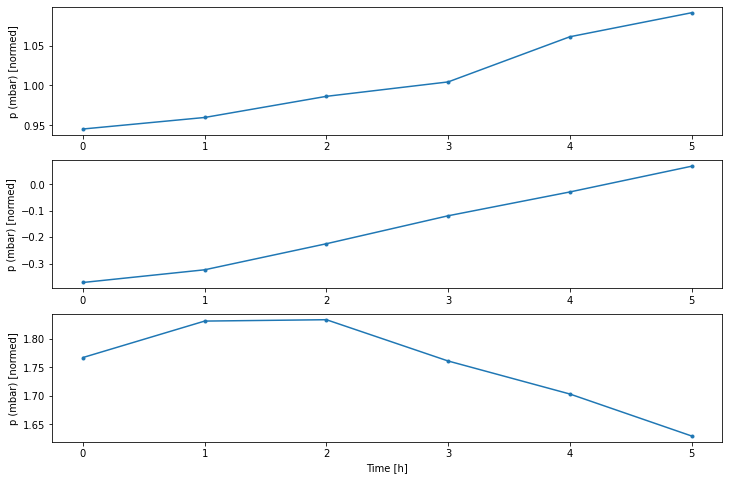

In [ ]:
w2.plot(plot_col='p (mbar)')

### 4. Creare `tf.data.Dataset`s

Infine, questo metodo `make_dataset` richiederà una serie temporale `dataframe` e poi di convertirlo in un `tf.data.Dataset` di `(input_window, label_window)` accoppiati utilizzando la funzione `preprocessing.timeseries_dataset_from_array`:

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

L'oggetto `WindowGenerator` contiene l'addestramento, la validazione e i dati di test.

Aggiungi proprietà per loro accesso come `tf.data.Dataset` utilizzando il metodo `make_dataset` definito in precedenza. Inoltre, aggiungi un batch di esempio standard per un facile accesso e tracciamento:

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Ora, l'oggettp `WindowGenerator` dà accesso agli oggetti `tf.data.Dataset`, in modo da poter facilmente iterare sui dati.

Il `Dataset.element_spec` proprietà che dice la struttura, i tipi di dati, e le forme degli elementi del set di dati.

In [ ]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

Iterando su `Dataset` si generano batches (raggruppamenti di dati):

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

## Modello a passo singolo (Single step models)

Il modello più semplice che puoi costruire su questo tipo di dati è quello che prevede il valore di una singola caratteristica: 1 passaggio temporale (un'ora) nel futuro in base solo alle condizioni attuali.

Quindi, inizia con la costruzione di modelli per prevedere il `T (degC)` valore di 1h nel futuro.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Configurare un `WindowGenerator` oggetto per produrre queste coppie single-step `(input, label)`:

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

L'oggetto `window` crea una serie di istanze `tf.data.Dataset` dall'addestramento, la validazione e il test, che consente di iterare facilmente su batch di dati.

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Prima di costruire un modello addestrabile sarebbe bene avere una baseline delle prestazioni come punto di confronto con i modelli successivi più complicati.

Questo primo compito è prevedere la temperatura 1h nel futuro, dato il valore attuale di tutte le caratteristiche. I valori attuali includono la temperatura attuale.

Quindi, inizia con un modello che restituisce solo la temperatura corrente come previsione, prevedendo "Nessun cambiamento". Questa è una baseline ragionevole poiché la temperatura cambia lentamente. Ovviamente, questa baseline funzionerà meno bene se fai una previsione ulteriormente in futuro.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Istanziamo e valutiamo il modello:

In [ ]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 4s 7ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


Questo modello ha stampato alcune metriche sulle prestazioni, ma quelle non ti danno un'idea di quanto bene stia andando il modello.

Il `WindowGenerator` ha un metodo di stampa, ma le stampe non sarà molto interessante con un solo campione.

Quindi, creare un più ampio `WindowGenerator` che genera le finestre 24h di input e le etichette consecutive alla volta. La nuova variabile `wide_window` non cambia il modo in cui il modello funziona. Il modello fa ancora previsioni 1h nel futuro in base a un singolo passaggio temporale di input. Qui, l'asse `time` agisce come l'asse `batch`: ogni stima viene effettuata indipendentemente senza alcuna interazione tra fasi temporali:

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Questa finestra espansa può essere passata direttamente alla stessa `baseline` del modello, senza modifiche al codice. Ciò è possibile perché gli input e le etichette hanno lo stesso numero di passaggi temporali e la `baseline` inoltra semplicemente l'input all'output:

![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Tracciando le previsioni del modello di base, nota che sono semplicemente le etichette spostate a destra di un'ora:

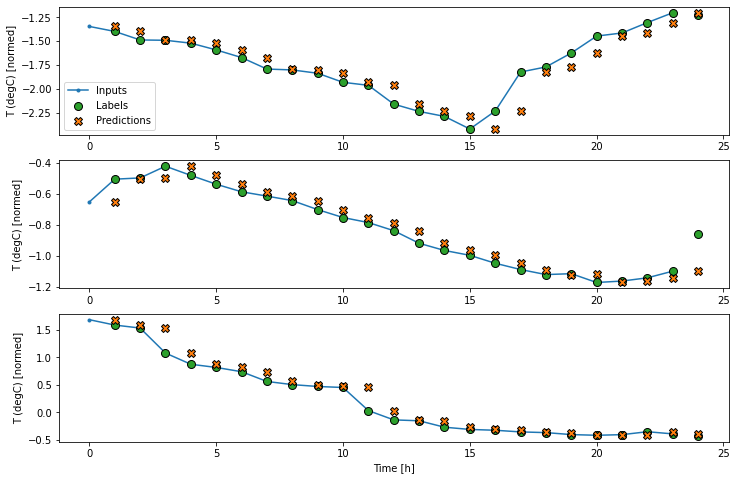

In [ ]:
wide_window.plot(baseline)

Nei grafici sopra dei tre esempi il modello a passo singolo viene eseguito nel corso di 24h. Questo merita qualche spiegazione:

- Linea blu (`Inputs`) indica la temperatura di ingresso ad ogni passo. Il modello riceve tutte le caratteristiche, questo grafico mostra solo la temperatura.
- Punti verdi (`Labels`) indicano il valore di previsione di destinazione. Questi punti vengono visualizzati all'ora di previsione, non all'ora di input. Ecco perché l'intervallo di etichette viene spostato di 1 passo rispetto agli ingressi.
- Croci arancioni (`Predictions`) sono la previsione del modello è per ogni passo temporale di uscita. Se il modello prevedevano perfettamente le previsioni sarebbero atterrare direttamente sulle `Labels` .

### Modello Lineare

Il più semplice modello **addestrabile** consiste nell'inserire una trasformazione lineare tra l'ingresso e l'uscita. In questo caso l'output di un passo temporale dipende solo da quel passo:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Un layer `tf.keras.layers.Dense` senza `activation` è un semplice modello lineare. Il layer trasforma solo l'ultima dimensione dei dati da `(batch, time, inputs)` a `(batch, time, units)` ; viene applicata indipendentemente a ogni elemento di tutte le dimensioni `batch` e `time`.

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


Questo tutorial addestra molti modelli, quindi conviene impacchettarli tutti in una sola funzione:

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Addestriamo il modello e valutiamo le sue performances:

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Come la `baseline` del modello, il modello lineare può essere chiamato su `batch` di ampie finestre. Usato in questo modo, il modello effettua una serie di previsioni indipendenti su fasi temporali consecutive. La dimensione `time`  agisce come un altra dimensione `batch. Non ci sono interazioni tra le previsioni in ogni fase temporale.

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Ecco la stampa dei suoi esempi di previsioni sul `wide_window`, nota come in molti casi, la previsione è chiaramente meglio che ritornare semplicemente solo il valore della temperatura di ingresso, ma in alcuni casi è peggio:

In [ ]:
wide_window.plot(linear)

Un vantaggio dei modelli lineari è che sono relativamente semplici da interpretare. Puoi estrarre i pesi del livello e visualizzare il peso assegnato a ciascun input (misurando cosi' la rilevanza statistica):

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

A volte il modello non ha nemmeno da' maggior peso all'ingresso `T (degC)` . Questo è uno dei rischi dell'inizializzazione casuale.

### Dense Model

Prima di applicare modelli che operano effettivamente su più fasi temporali, vale la pena controllare le prestazioni di modelli a fase di input singola più profondi, più potenti.

Ecco un modello simile a `linear` modello, tranne che impila diversi alcuni `Dense` strati tra l'ingresso e l'uscita:

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

### Multi-step dense

Un modello a passo singolo non ha contesto per i valori correnti dei suoi input. Non può vedere come le caratteristiche di input cambiano nel tempo. Per risolvere questo problema, il modello deve accedere a più fasi temporali durante l'esecuzione delle previsioni:

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


I modelli `baseline` , `linear` e `dense` sono trattati ogni passo temporale indipendente. Qui il modello richiederà più passaggi temporali come input per produrre un singolo output.

Creare un `WindowGenerator` che produrrà batch di ingressi di 3h ed etichette di 1h:

Si noti che il parametro di shift per la `Window` è relativo alla fine delle due finestre.

In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

In [ ]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

Si potrebbe formare un modello `dense` su una finestra multi-step input dopo l'aggiunta di un layer `tf.keras.layers.Flatten` come primo livello del modello:

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

In [ ]:
conv_window.plot(multi_step_dense)

Il principale svantaggio di questo approccio è che il modello risultante può essere eseguito solo su finestre di input esattamente di questa forma e dimensione.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

I modelli convoluzionali nella sezione successiva risolvono questo problema.

### Convolution neural network

Uno strato convoluzione (`tf.keras.layers.Conv1D`) gestisce anche più passaggi temporali come ingresso a ciascun predizione.

Di seguito è riportato lo **stesso** modello `multi_step_dense` , ri-scritto con una convoluzione.

Nota le modifiche:

* Il layer `tf.keras.layers.Flatten` e il primo layer `tf.keras.layers.Dense` sono sostituiti da un layer `tf.keras.layers.Conv1D`.
* Il layer `tf.keras.layers.Reshape` non è più necessario in quanto la convoluzione mantiene la dimensione su cui si muove nella sua uscita.

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Eseguiamolo su un batch di esempio per verificare che il modello produca output con la forma prevista:

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Addestrare e valutare il modello sul `conv_window` e dovrebbe fornire prestazioni simili al modello `multi_step_dense`.

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

La differenza tra questo modello `conv_model` e il modello `multi_step_dense` è che il `conv_model` può essere eseguito su input di qualsiasi lunghezza. Il livello convoluzionale viene applicato a una finestra scorrevole di input:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

Se lo esegui su un input più ampio, produce un output più ampio:

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Notare che l'output è più corto dell'input. Per far funzionare l'addestramento o la stampa, è necessario che le etichette e la previsione abbiano la stessa lunghezza. Quindi costruire un `WindowGenerator` per la produzione di ampie finestre con pochi passi in più di tempo di ingresso in modo che le etichette e di previsione lunghezze corrispondono:

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Ora possiamo tracciare le previsioni del modello su una finestra più ampia. Nota le 3 fasi temporali di input prima della prima previsione. Ogni previsione qui si basa sui 3 passaggi temporali precedenti:

In [ ]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

Una rete neurale ricorrente (RNN) è un tipo di rete neurale adatta ai dati di serie temporali (sequenze). Le RNN elaborano una serie temporale passo dopo passo, mantenendo uno stato interno da un passo all'altro.

Potete saperne di più nella [generazione di testo con le RNN](https://www.tensorflow.org/text/tutorials/text_generation) con un tutorial sulle RNN e la guida [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn).

In questa esercitazione, si utilizzerà un layer RNN chiamato a 'Long Short Term Memory' (`tf.keras.layers.LSTM`).

Un argomento del costruttore della classe importante per tutti i livelli di  Keras RNN, come `tf.keras.layers.LSTM`, è l'argomento `return_sequences`. Questa impostazione può configurare il layer in due modi:

1. Se `False` , l'impostazione predefinita, lo strato restituisce solo l'uscita della fase finale di tempo, dando il tempo del modello per calcolare il suo stato interno prima di fare una sola previsione: 

![An LSTM warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. Se `True` , lo strato restituisce un output per ogni ingresso. Questo è utile per:
  * Sovrapposizione di strati RNN.
  * Addestramento di un modello su più fasi temporali contemporaneamente.

![An LSTM making a prediction after every time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)








In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

Con `return_sequences=True` , il modello può essere addestrato su 24h di dati alla volta.

Questo darà una visione pessimistica della performance del modello. Sul primo gradino tempo, il modello non ha accesso alle fasi precedenti e, quindi, non può fare di meglio rispetto alla semplice `linear` e `dense` modelli mostrato in precedenza.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [ ]:
wide_window.plot(lstm_model)

### Performance

Con questo set di dati in genere ciascuno dei modelli fa leggermente meglio di quello precedente:

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

### Multi-output models

I modelli finora tutto previsto Funzione uscita singola, `T (degC)` per un singolo passo temporale.

Tutti questi modelli possono essere convertiti per prevedere molteplici funzioni semplicemente cambiando il numero di unità nello strato di output e di ridimensionare le finestre di formazione per includere tutte le funzioni nelle `labels` (`example_labels`):

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Nota sopra che la dimensione `features` di etichette ora ha la stessa profondità ingressi, invece di `1`.

#### Baseline

Il modello `baseline` può essere utilizzato in questo caseo, ma questa volta ripetere tutte le caratteristiche invece di selezionare uno specifico `label_index`:

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

#### Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

#### RNN


In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

<a id="residual"></a>

#### Advanced: Residual connections

Il modello `baseline` ha approfittato del fatto che la sequenza non cambia drasticamente tra ciascun passo temporale. Ogni modello addestrato in questo tutorial finora è stato inizializzato in modo casuale e quindi ha dovuto apprendere che l'output è una piccola modifica rispetto al passaggio temporale precedente.

Sebbene sia possibile aggirare questo problema con un'attenta inizializzazione, è più semplice integrarlo nella struttura del modello.

È comune nell'analisi delle serie temporali il fatto di creare modelli che invece di prevedere il valore successivo, prevedono come il valore cambierà nel passaggio temporale successivo. Analogamente, <a href="https://arxiv.org/abs/1512.03385" class="external">ResNet</a> nell'apprendimento profonda riferiscono alle architetture dove ogni strato aggiunge al risultato accumulo del modello.

È così che approfitti della consapevolezza che il cambiamento dovrebbe essere piccolo.

![A model with a residual connection](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/residual.png?raw=1)

In sostanza, questo inizializza il modello che corrisponda al `Baseline`. Cio' aiuta i modelli a convergere più velocemente, con prestazioni leggermente migliori.

Questo approccio può essere utilizzato insieme a qualsiasi modello discusso in questo tutorial.

Qui, viene applicato al modello `LSTM`, notare l'uso delle `tf.initializers.zeros` per assicurare che i cambiamenti previsti iniziali sono piccoli, e non sovraccaricano la connessione residuo. Non ci sono problemi di simmetria di rottura per i gradienti qui, poiché i `zeros` vengono utilizzati solo sull'ultimo livello.

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

#### Performance

Ecco le prestazioni complessive per questi modelli multi-output.

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Le prestazioni di cui sopra sono mediate su tutti gli output del modello.

## Multi-step models

Entrambi i modelli `multiple-output` e `single-output` presentati nelle sezioni precedenti fanno **previsioni passo singolo tempo**, 1h nel futuro.

Questa sezione esamina come espandere questi modelli per generare **più step di previsioni temporali**.

In una previsione a più passaggi, il modello deve imparare a prevedere un intervallo di valori futuri. Pertanto, a differenza di un modello `single-step`, in cui è previsto solo un singolo valore per il futuro, un modello a più step prevede una sequenza dei valori futuri.

Ci sono due approcci a questo:

1. Previsioni a `single-shot` in cui viene prevista l'intera serie temporale contemporaneamente.
2. Previsioni `autoregressive` in cui il modello effettua solo previsioni a passaggio singolo e il suo output viene restituito come input.
In questa sezione tutti i modelli prevederanno **tutte le caratteristiche in tutte le fasi temporali di uscita**.


Per il modello a più passaggi, i dati di addestramento sono nuovamente costituiti da campioni orari. Tuttavia, qui, i modelli impareranno a prevedere 24 ore nel futuro, date 24 ore del passato.

Ecco un oggetto `Window` che genera queste estrazioni (slice) dal dataset:

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

Una semplice `baseline` per questa attività consiste nel ripetere l'ultimo passaggio temporale di input per il numero richiesto di passaggi temporali di output:

![Repeat the last input, for each output step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Poiché questo compito è prevedere 24h nel futuro, date 24h del passato, un altro semplice approccio è ripetere il giorno precedente, supponendo che il domani sarà simile:

![Repeat the previous day](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_repeat.png?raw=1)

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

Un approccio di alto livello a questo problema consiste nell'utilizzare un modello *"single-shot"*, in cui il modello esegue l'intera previsione della sequenza in un unico passaggio.

Ciò può essere implementato in modo efficiente come `tf.keras.layers.Dense` con `OUT_STEPS*features` unità di uscita. Il modello ha solo bisogno di rimodellare che la produzione alle richieste `(OUTPUT_STEPS, features)`.

#### Lineare

Un semplice modello lineare basato sull'ultimo passaggio temporale di input funziona meglio di entrambe le `baseline`, ma è sottodimensionato. Il modello deve prevedere `OUTPUT_STEPS` passi temporali, da un singolo passo temporale di ingresso con una proiezione lineare. Può catturare solo una piccola parte del comportamento, probabilmente basata principalmente sull'ora del giorno e sul periodo dell'anno.

![Predict all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Aggiungendo un `tf.keras.layers.Dense` tra l'ingresso e l'uscita aumenta l'accuratezza del modello lineare, ma è ancora basata su un solo passo temporale di ingresso.

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

Un modello convoluzionale effettua previsioni basate su una cronologia a larghezza fissa, che può portare a prestazioni migliori rispetto al modello denso poiché può vedere come le cose cambiano nel tempo:

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

Un modello ricorrente può imparare a utilizzare una lunga storia di input, se è rilevante per le previsioni che il modello sta facendo. Qui il modello accumulerà lo stato interno per 24h, prima di fare una singola previsione per le 24h successive.

In questo formato `single-shot`, l'`LSTM` ha solo bisogno di produrre un output all'ultimo passo di tempo, in modo da impostare `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)


In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

I modelli di cui sopra prevedono tutti l'**intera sequenza di output** in un unico passaggio.

In alcuni casi può essere utile per il modello scomporre questa previsione in singole fasi temporali. Quindi, l'uscita di ciascun modello può essere immessa nella stessa ad ogni passo e le previsioni può essere condizionata da un precedente, come nei classici <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

Un chiaro vantaggio di questo stile di modello è che può essere impostato per **produrre output con una lunghezza variabile**.

Potresti prendere uno qualsiasi dei modelli `multi-output` a `single-step` addestrati nella prima metà di questo tutorial ed eseguire un ciclo di feedback autoregressivo, ma qui ci concentreremo sulla creazione di un modello che è stato esplicitamente addestrato per farlo.


![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)

#### RNN

Questo tutorial crea solo un modello RNN autoregressivo, ma questo modello può essere applicato a qualsiasi modello progettato per produrre un singolo passaggio temporale.

Il modello avrà la stessa forma di base dei modelli LSTM singolo passo da meno: un layer `tf.keras.layers.LSTM` seguito da un layer `tf.keras.layers.Dense` che converte le uscite del livello `LSTM` di previsioni dei modelli.

Un layer `tf.keras.layers.LSTM` è un layer `tf.keras.layers.LSTMCell` avvolto nel livello più alto `tf.keras.layers.RNN` che gestisce i risultati del livello e della sequenza.

In questo caso, il modello deve gestire manualmente gli ingressi per ogni passo, in modo che si utilizzi `tf.keras.layers.LSTMCell` direttamente per il livello inferiore, a singola interfaccia fase temporale.

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

Questo modello ha bisogno di un metodo `warmup` per inizializzare il suo stato interno in base agli input. Una volta addestrato, questo stato acquisirà le parti rilevanti della cronologia degli input. Questo è equivalente al modello `single-step` di `LSTM` illustrato in precedenza:

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

Questo metodo restituisce un singolo pronostico di 1 passo temporale e lo stato interno del `LSTM`:

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

Con lo stato della `RNN` e una previsione iniziale si può continuare iterare il modello fornendo le predizioni a ciascun passo precedente come input.

L'approccio più semplice per raccogliere le previsioni di uscita è quella di utilizzare una lista Python e un `tf.stack` dopo il ciclo.

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Proviamo a eseguire questo modello sugli input di esempio:

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Ora, addestriamo il modello:

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

Ci sono chiaramente rendimenti decrescenti in funzione della complessità del modello su questo problema:

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

Le metriche per i modelli `multi-output` nella prima metà di questa esercitazione mostrano la media delle prestazioni tra tutte le funzionalità di output. Queste prestazioni sono simili ma sono anche mediate tra le fasi temporali di output.

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

I miglioramenti ottenuti passando da un modello denso a modelli convoluzionali e ricorrenti sono solo di una piccola percentuale (se ce ne sono) e il modello autoregressivo ha funzionato nettamente peggio. Quindi, questi approcci più complessi potrebbero non valere la pena su questo tipo di problema, ma non c'era modo di saperlo in anticipo, senza cercare, e questi modelli potrebbero essere utili per il vostro problema ( o per un problema piu' complesso).

## Next steps

Questo tutorial era basato sul tutorial di Tensorflow <a href="https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_autoregressive_model" class="external">Time Series Forecasting Tutorial Tensorflow</a>. Per ulteriori dettagli leggere il tutorial originale (di cui si e' mantenuta la struttura principale)
